# 1. ML Ops: Generalities

## 1.1 Context

## 1.2 MLFlow

# 2. Bike Sharing Demand Dataset (Kaggle)

## 2.1 Context

## 2.2 The dataset

Features:
- Date/time: of the the bike rental
- Weather conditions: Temperature, humidity, wind speed, etc
- Seasonal factors: Year, month, holiday/weekend vs workday
- Rental counts: number of bikes rented at agiven time = the target variable to be predicted

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import mlflow
import sklearn

In [2]:
# inches -> cm conversion for plotting
cm=1/2.54

In [3]:
from pathlib import Path
path_data = Path('/home/lemasle/ASTRO/projects/bike-prediction-mlops/data')
path_figs = Path('/home/lemasle/ASTRO/projects/bike-prediction-mlops/figs')

In [4]:
train = pd.read_csv(path_data / 'train.csv')
print('number of rows in the training data', len(train))
unseen = pd.read_csv(path_data / 'test.csv')
print('number of rows in the unseen data', len(unseen))

number of rows in the training data 10886
number of rows in the unseen data 6493


In [5]:
data = train

## 2.3 Data cleaning

### 2.3.1 Missing values

In [7]:
print(len(data))

10886


In [8]:
data_missing_values = data.isnull().sum()
print(data_missing_values)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


### 2.3.2 Outliers

Text(0.5, 1.0, 'Distribution of weather parameters')

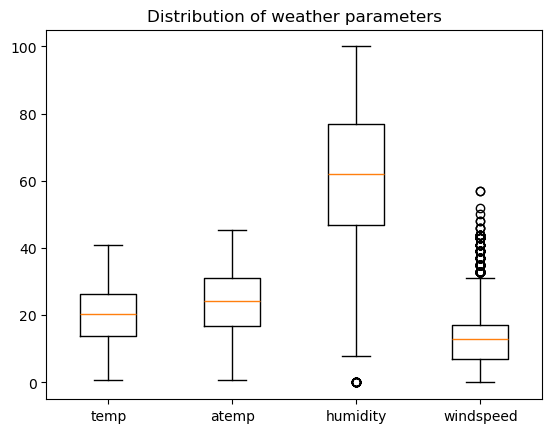

In [9]:
data_outliers = data.loc[:, ['temp', 'atemp', 'humidity', 'windspeed']]
plt.boxplot(data_outliers, tick_labels=data_outliers.columns)
plt.title('Distribution of weather parameters')

In [10]:
data['windspeed'] = data['windspeed'].clip(upper=40)

### 2.3.3 Wrong data

In [11]:
data_wrong = data[data['windspeed'] < 0]
print(len(data_wrong))

0


There are no columns with obviously wrong data, such as negative windspeed

### 2.3.4 Day type

Check whether a holiday could nevertheless be a working day:

In [12]:
test_day = data.loc[(data['holiday'] == 1) & (data['workingday'] == 1)]
print(len(test_day))

0


## 2.4 Feature Engineering

### 2.4.1 Datetime data

In [13]:
# Convert 'datetime' column to datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

# Create new features
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month

### 2.4.2 Weather

The 'weather' column is already categorical, so we could leave it like that.
On the other hand, it is possible to further refine it, for instance to indicate weather it is raining or not (an important criterion when choosing to bike or not, speaking from experience).
This can be done via binary features: is_clear_weather / is_rainy.
Such features slightly simplifies the relationship with the target variable.

In [14]:
# Create binary weather features
data['is_clear_weather'] = (data['weather'] == 1).astype(int)
data['is_rainy_weather'] = (data['weather'] >= 3).astype(int)

### 2.4.3 Drop now irrelevant columns

In [15]:
data.drop(columns=['datetime', 'weather', 'casual', 'registered'], inplace=True)

## 2.5 Training and Testing Split

In [17]:
# Split the data into features and target
X = data.drop(columns=["count"])  # Features (all columns except 'count')
y = data["count"]  # Target variable

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Verify the split
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")

Training data size: (8708, 12)
Testing data size: (2178, 12)


In [20]:
print(y_train.shape, y_test.shape)

(8708,) (2178,)


# 3. Setup of the MLOps pipeline

## 3.1 python setup

In [21]:
# Strictly speaking, it serves no purpose (other than educational) to repeat this here since we already experimented with the dataset in Section 2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import mlflow
import sklearn

## 3.2 MLFlow tracking setup

In [22]:
def plot_feature_importance(model, X_train, path_figs, filename, cm):

    feature_importances = model.feature_importances_
    fig, ax = plt.subplots(figsize=(10*cm, 6*cm))
    ax.barh(X_train.columns, feature_importances)
    ax.set_title("Feature Importance")

    file = Path(path_figs / str(filename))
    fig.savefig(file)

### 3.2.1 Define the model and the GridSearchCV

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
# define the grid of hyperparameters
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10, 15, 20]
}
random_state = 42

In [26]:
# define the model model
model = DecisionTreeRegressor(random_state=random_state)

In [27]:
# Define the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

### 3.2.2 Start an MLFlow run

Run a local Tracking Server

In [28]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [29]:
my_experiment = mlflow.set_experiment("/mlflow_bike_sharing_forecast")

In [30]:
print(my_experiment.experiment_id)

101887636968754225


71fa669f061349aa87dc83ea33a8dbe9
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/lemasle/miniforge3/envs/MLOPS/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
2024/12/05 17:56:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/05 17:56:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run bike_sharing_GridSearchCV_DecisionTreeRegressor_2024-12-05 at: http://127.0.0.1:8080/#/experiments/101887636968754225/runs/71fa669f061349aa87dc83ea33a8dbe9.
2024/12/05 17:56:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/101887636968754225.


    param_max_depth  param_min_samples_split  \
0                 5                        2   
1                 5                        5   
2                 5                       10   
3                 5                       15   
4                 5                       20   
5                10                        2   
6                10                        5   
7                10                       10   
8                10                       15   
9                10                       20   
10               15                        2   
11               15                        5   
12               15                       10   
13               15                       15   
14               15                       20   

                                        params  mean_test_score  \
0     {'max_depth': 5, 'min_samples_split': 2}    -13183.309995   
1     {'max_depth': 5, 'min_samples_split': 5}    -13183.309995   
2    {'max_depth': 5, 'min_sam

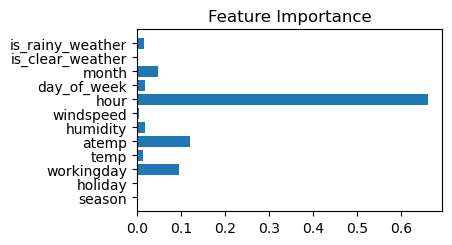

In [31]:
# Give the run a name
today = dt.date.today()
run_name = "bike_sharing_GridSearchCV_DecisionTreeRegressor_" + str(today)
# NOTE: run_name is not necessarily unique 

with mlflow.start_run(run_name=run_name) as run:
   
    # get run_id:
    print(run.info.run_id)
    
    # Perform grid search
    best_DT = grid_search.fit(X_train, y_train)
    
    # Log the best hyperparameters
    best_params = grid_search.best_params_
    mlflow.log_param("best_max_depth", best_params['max_depth'])
    mlflow.log_param("best_min_samples_split", best_params['min_samples_split'])
    
    # Log the best score (cross-validated)
    best_score = -grid_search.best_score_  # "-" because we used 'neg_mean_squared_error' for scoring
    mlflow.log_metric("best_cross_val_score", best_score)
    
    # Log the final model
    best_model = grid_search.best_estimator_
    mlflow.sklearn.log_model(best_model, "best_model")

    # Plot feature importance
    plot_feature_importance(best_model, X_train, path_figs, 'feature_importance.pdf', cm)
    
    # Log feature importance as an artifact
    mlflow.log_artifact(Path(path_figs / 'feature_importance.pdf'))

    # collect all results
    individual_results = pd.DataFrame(best_DT.cv_results_)
    results = individual_results[['param_max_depth', 'param_min_samples_split', 'params', 
                                 #'split0_test_score', 'split1_test_score', 'split2_test_score',
                                 #'split3_test_score', 'split4_test_score',  
                                  'mean_test_score', 'std_test_score', 'rank_test_score']]
    # show dataframe
    print(results)

    # Evaluate the model on the test set and log the result
    test_predictions = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, test_predictions)
    mlflow.log_metric("test_MAE", test_mae)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mlflow.log_metric("test_RMSE", test_rmse)
    
    # end the run
    mlflow.end_run()
    
print(f"Best Hyperparameters: {best_params}")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")

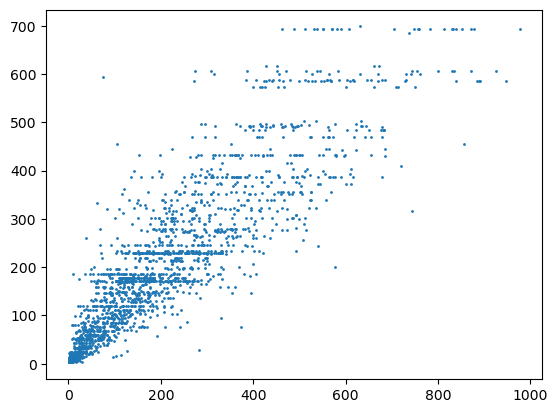

In [32]:
#TBD 
plt.scatter(y_test,test_predictions, s=1)

### 3.2.3 Get MLFlow data

In [33]:
# Create DataFrame of all runs in the current experiment
df_all = mlflow.search_runs(order_by=["start_time DESC"])
print(df_all.columns)

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.test_RMSE', 'metrics.best_cross_val_score',
       'metrics.test_MAE', 'params.best_max_depth',
       'params.best_min_samples_split', 'tags.mlflow.runName',
       'tags.mlflow.source.name', 'tags.mlflow.user',
       'tags.mlflow.log-model.history', 'tags.mlflow.source.type'],
      dtype='object')


In [35]:
# Print a list of the columns available
# print(list(df.columns))

# Create DataFrame with subset of columns
df_runs = df_all[   [
        "run_id",
        "experiment_id",
        "status",
        "metrics.test_MAE",
        "metrics.test_RMSE",
        "metrics.best_cross_val_score",
        "params.best_min_samples_split",
        "params.best_max_depth",
        "tags.mlflow.source.type",
        "tags.mlflow.source.name",
        "tags.mlflow.log-model.history", 
        "tags.mlflow.runName",
        "tags.mlflow.user",
        ]
].copy()
df_runs.head()

,run_id,experiment_id,status,metrics.test_MAE,metrics.test_RMSE,metrics.best_cross_val_score,params.best_min_samples_split,params.best_max_depth,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.runName,tags.mlflow.user
0,71fa669f061349aa87dc83ea33a8dbe9,101887636968754225,FINISHED,53.472478,80.446702,6577.248034,20,10,LOCAL,/home/lemasle/miniforge3/envs/MLOPS/lib/python...,"[{""run_id"": ""71fa669f061349aa87dc83ea33a8dbe9""...",bike_sharing_GridSearchCV_DecisionTreeRegresso...,lemasle
1,6314d6c1ac654881ab8db25e40da75ee,101887636968754225,RUNNING,NaN,NaN,NaN,None,None,LOCAL,/home/lemasle/miniforge3/envs/MLOPS/lib/python...,"[{""run_id"": ""6314d6c1ac654881ab8db25e40da75ee""...",ambitious-crow-476,lemasle
2,7eb18b648e874682b0a846849a5348db,101887636968754225,FINISHED,53.472478,80.446702,6577.248034,20,10,LOCAL,/home/lemasle/miniforge3/envs/MLOPS/lib/python...,"[{""run_id"": ""7eb18b648e874682b0a846849a5348db""...",bike_sharing_GridSearchCV_DecisionTreeRegresso...,lemasle


In [36]:
# TBD PYFUNC?

## 3.3 MLFlow project setup

name: BikeSharingPrediction

conda_env: conda.yaml

entry_points:
  main:
    command: "python train.py"

## 3.4 MLFlow models setup

In [37]:
import mlflow.sklearn

# Log the model
mlflow.sklearn.log_model(model, "model")

2024/12/05 17:58:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 3.5 MLFlow Registry setup 

In [38]:
path_reg_mod = str('runs:/') + str(run.info.run_id) + str('/model')
print(path_reg_mod)

runs:/71fa669f061349aa87dc83ea33a8dbe9/model


In [39]:
result = mlflow.register_model(path_reg_mod, "BikeSharingPredictionModel")

Registered model 'BikeSharingPredictionModel' already exists. Creating a new version of this model...
2024/12/05 17:58:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BikeSharingPredictionModel, version 2
Created version '2' of model 'BikeSharingPredictionModel'.


# Conclusion/Summary

# DRAFT